In [2]:
# cran packages
x <- c('dplyr',
       'data.table',
       'tidyr',   
       'tidyverse', 
       'ggplot2', 
       'plotly')
# bioconductor packages
y <- c('DEP', 
       'limma', 
       'DESeq2', 
       'SummarizedExperiment')

In [ ]:
# install cran packages
for (pkg in x) {
    if (!pkg %in% rownames(installed.packages())) {install.packages(pkg)}
}

In [ ]:
# install bioconductor packages
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")
for (pkg in y) {
    if (!requireNamespace(pkg, quietly=TRUE)) {
        BiocManager::install(pkg)
    }
}

In [3]:
# load packages
load_lib <- function(x) {
    suppressPackageStartupMessages(library(x, character.only = TRUE))
}
invisible(lapply(c(x, y), load_lib))

## Data

The SummarizedExperiment object has a couple of specifications. The log2-transformed assay data and the specified rowData and colData columns are prerequisites for the subsequent analysis steps.
- The assay data is log2-transformed. 
- Its rownames depict the protein/gene names. The rowData contains, amongst others, the ‘name’ and ‘ID’ columns.
- The colData contains the experimental design and thereby the sample annotation. Thereby the colData includes the ‘label’, ‘condition’ and ‘replicate’ columns as well as a newly generated ‘ID’ column.  

In [25]:
data <- readRDS('./data/AMLproteomics_imp_norm_se_list2021-04-06.rds')
data <- data$lenient  # choose conservative or lenient
# The following is to format the data to match the function requirement 
colData(data) <- subset(colData(data), select = -c(condition, replicate)) 
names(colData(data))[names(colData(data)) == 'Treatment.history'] <- 'condition'
colData(data)$condition  <- as.factor(colData(data)$condition) # need to be factors for deseq2
colData(data)$replicate <- colData(data)$ID 
colData(data) <- subset(colData(data), select = c(ID, label, condition, replicate, Diagnosis))
data <- data[, !is.na(colData(data)$condition)] # remove samples with NA condition

In [26]:
data

class: SummarizedExperiment 
dim: 4688 44 
metadata(0):
assays(1): ''
rownames(4688): A2M A8MWD9 ... ZYX ZZEF1
rowData names(6): hgnc_symbol ProteinGroupId ... imputed num_NAs
colnames(44): CTG_2226 CTG_2227 ... CTG_3679 CTG_3680
colData names(5): ID label condition replicate Diagnosis

In [27]:
# assay data
dim(assay(data))
head(assay(data), 2)

[1] 4688   44

,CTG_2226,CTG_2227,CTG_2228,CTG_2229,CTG_2232,CTG_2233,CTG_2234,CTG_2235,CTG_2236,CTG_2238,...,CTG_3441,CTG_3659,CTG_3660,CTG_3661,CTG_3663,CTG_3670,CTG_3673,CTG_3674,CTG_3679,CTG_3680
A2M,15.386,15.65601,16.38401,14.84999,15.84399,13.96596,13.74704,12.77808,14.961,16.10501,...,14.04397,14.16703,14.633,14.19599,14.85599,16.511,16.103,13.30307,16.764,14.975
A8MWD9,18.122,18.84500,18.90100,19.04300,18.11900,18.30000,18.77900,18.71000,19.251,18.82300,...,19.03400,18.22900,18.100,18.99500,18.63300,18.798,18.729,18.82300,18.432,18.730


In [28]:
# row info: gene
dim(rowData(data))
head(as.data.frame(rowData(data)), 2)

[1] 4688    6

,hgnc_symbol,ProteinGroupId,ID,name,imputed,num_NAs
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
A2M,A2M,P01023,P01023,A2M,FALSE,0
A8MWD9,NA,A8MWD9,A8MWD9,A8MWD9,FALSE,0


In [29]:
# column info: sample
dim(colData(data))
head(as.data.frame(colData(data)), 2)

[1] 44  5

,ID,label,condition,replicate,Diagnosis
,<chr>,<chr>,<fct>,<chr>,<fct>
CTG_2226,CTG_2226,CTG_2226,PRETREATED,CTG_2226,REFRACTORY
CTG_2227,CTG_2227,CTG_2227,PRETREATED,CTG_2227,RELAPSED


In [30]:
# summary of pretreated vs. naive
table(colData(data)$condition, useNA = "always")


     NAIVE PRETREATED       <NA> 
        15         29          0 

## Processing

In [31]:
# Normalize the data
data_norm <- normalize_vsn(data)

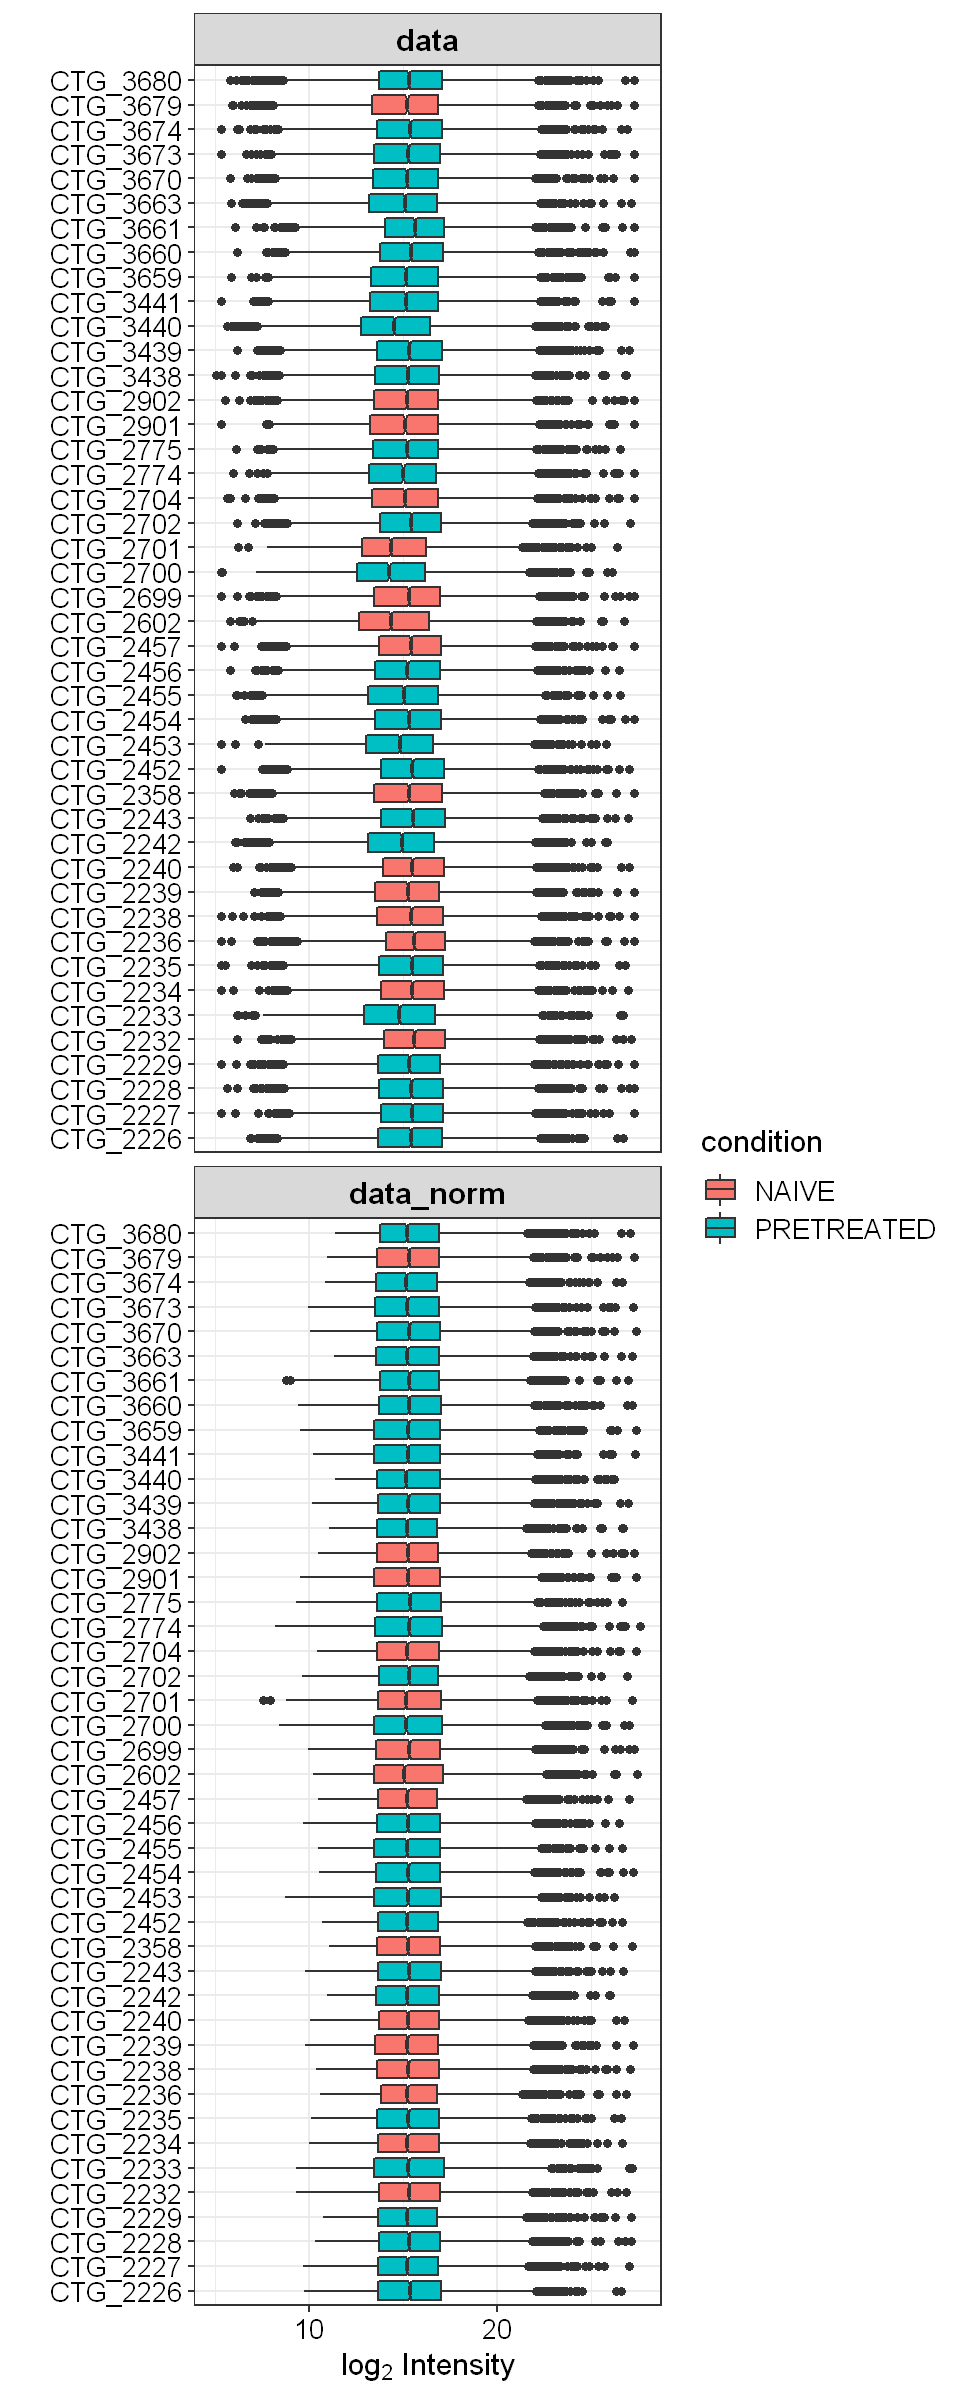

In [32]:
# Visualize normalization by boxplots for all samples before and after normalization
options(repr.plot.width=6, repr.plot.height=15, repr.plot.res=160)
plot_normalization(data, data_norm)

## Differential protein expression

Here, fold change is defined as the ratio of the difference between final value and the initial value divided by the initial value. For quantities A and B, the fold change is given as (B − A)/A.

In [35]:
se  <- data
assay(se) <- round(2^assay(se)) # deseq2 uses counts instead of log2(counts)
head(assay(se), 2)
dds <- DESeqDataSet(se, design = ~ condition + Diagnosis)
dds <- DESeq(dds)
dds

,CTG_2226,CTG_2227,CTG_2228,CTG_2229,CTG_2232,CTG_2233,CTG_2234,CTG_2235,CTG_2236,CTG_2238,...,CTG_3441,CTG_3659,CTG_3660,CTG_3661,CTG_3663,CTG_3670,CTG_3673,CTG_3674,CTG_3679,CTG_3680
A2M,42820,51633,85522,29532,58819,16002,13749,7024,31894,70484,...,16891,18395,25408,18768,29655,93391,70386,10107,111293,32205
A8MWD9,285276,470880,489517,540150,284684,322737,449824,428816,623919,463754,...,536791,307239,280959,522474,406529,455787,434501,463754,353659,434802


renaming the first element in assays to 'counts'

converting counts to integer mode



ERROR: Error in DESeqDataSet(se, design = ~condition + Diagnosis): variables in design formula cannot contain NA: Diagnosis
